<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch10_NewtonForSystems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Newton's method for systems of (nonlinear) equations

Copyright Department of Applied Mathematics, University of Colorado Boulder.
Released under the BSD 3-clause license

In [4]:
import numpy as np
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
jax.config.update("jax_enable_x64", True)

## Example from textbook
Example 2 in section 10.1 of Burden and Faires (9th or 10th ed), reused in section 10.2

Consider the 3D nonlinear system
$$\begin{align}3x_1 - \cos(x_2x_3) - \frac12 &= 0 \\
x_1^2 - 81(x_2+0.1)^2 + \sin(x_3) + 1/06 &= 0 \\
e^{x_1x_2} + 20 x_3 + \frac{10\pi - 3}{3} &= 0
\end{align}$$

We can write this as
$$F(\vec{x}) = \vec{0}, \quad\vec{x}\in\mathbb{R}^3$$
and solve via Newton's method,
$$\vec{x}^{(k+1)} \gets \vec{x}^{(k)} - J_F( \vec{x}^{(k)} )^{-1} F(\vec{x}^{(k)})$$
where $J_F$ is the Jacobian of $F$.

**Or** we can rewrite as a fixed point equation
$$G(\vec{x}) = \vec{x}^{(k)}$$
and solve via the fixed point iteration
$$
\vec{x}^{(k+1)} \gets G(\vec{x}^{(k)}).
$$

We'll try it both ways

In [6]:
n = 3
def G(x):
    """ Example from book, modified to work with JAX """
    g = jnp.empty(3)
    # be careful, book uses x_1, x_2, x_3 which are x[0], x[1], x[2] since Python is 0-based
    # Also, we have to use this funny notation due to JAX requirements
    g=g.at[0].set( 1/3*jnp.cos(x[1]*x[2] ) + 1/6)
    g=g.at[1].set( 1/9*jnp.sqrt(x[0]**2 + jnp.sin(x[2]) + 1.06) - 0.1 )
    g=g.at[2].set( -1/20*jnp.exp(-x[0]*x[1]) - (10*jnp.pi - 3)/60)
    return g

F = lambda x : G(x) - x

# Or a little better, define F in the natural way, since for G we had to take sqrt
def F(x):
    g = jnp.empty(3)
    # be careful, book uses x_1, x_2, x_3 which are x[0], x[1], x[2] since Python is 0-based
    # Also, we have to use this funny notation due to JAX requirements
    g=g.at[0].set( 3*x[0] - jnp.cos(x[1]*x[2]) -1/2 )
    g=g.at[1].set( x[0]**2 - 81*(x[1]+0.1)**2 + jnp.sin(x[2]) + 1.06 )
    g=g.at[2].set( jnp.exp(-x[0]*x[1]) + 20*x[2] + (10*jnp.pi - 3)/3 )
    return g

and now define the **generic** algorithms:

In [16]:
def fixedPointIterations( G, x0, maxIts = 1e2, tol = 1e-15, errFcn = None ):
    maxIts = int(maxIts)
    x      = jnp.array( x0, copy=True )
    errHist = []
    if errFcn is not None:
        errHist.append( errFcn(x) )
        print(f'Iter {0:2d}, error is {errHist[-1]:7.2e}')
    for k in range(maxIts):
        Gx = G(x)
        if np.isfinite(Gx).all() == False:
            print(f'NaN encountered at iteration {k+1}')
            break
        if np.linalg.norm(Gx-x) < tol :
            print(f'Reached tolerance at iteration {k+1}')
            break
        x = Gx # fixed point iteration
        if errFcn is not None:
            errHist.append( errFcn(x) )
            print(f'Iter {0:2d}, error is {errHist[-1]:7.2e}')
    return x, errHist

def NewtonIterations( F, x0, maxIts = 1e2, tol = 1e-15, errFcn = None ):
    maxIts = int(maxIts)
    J      = jax.jacrev(F)  # find Jacobian
    x      = jnp.array( x0, copy=True)
    errHist = []
    if errFcn is not None:
        errHist.append( errFcn(x) )
        print(f'Iter {0:2d}, error is {errHist[-1]:7.2e}')
    for k in range(maxIts):
        Jx = J(x)
        #print(f'Iter {k+1:2d}, condition number is {jnp.linalg.cond(Jx):.2e}')
        step = jnp.linalg.solve(Jx,F(x))
        x = x.at[:].subtract( step ) # make JAX happy
        if errFcn is not None:
            errHist.append( errFcn(x) )
            print(f'Iter {0:2d}, error is {errHist[-1]:7.2e}')
        if np.isfinite(x).all() == False:
            print(f'NaN encountered at iteration {k+1}')
            break
        if np.linalg.norm(step) < tol :
            print(f'Reached tolerance at iteration {k+1}')
            break
    return x, errHist

Let's run this and get the "true" answer (not really the perfect answer, but good enough).  Note: we went through debugging steps (not shown) so that we have faith in (1) our Newton implementation, and (2) our JAX implementation of F.

In [11]:
x0 = [.1,.1,-.1]
xTrue = NewtonIterations( F, x0 )[0]
errFcn = lambda x : jnp.linalg.norm(x-xTrue)/jnp.linalg.norm(xTrue)

Reached tolerance at iteration 6


Now let's rerun it with some output so we can see how it is converging

In [17]:
print('== Running fixed point iteration ==')
x, errHistFixedPt = fixedPointIterations( G, x0, errFcn = errFcn )
print(x)

print("== Running Newton's method ==")
x, errHistNewton = NewtonIterations( F, x0, errFcn=errFcn )
print(x)

== Running fixed point iteration ==
Iter  0, error is 8.16e-01
Iter  0, error is 1.31e-02
Iter  0, error is 3.27e-04
Iter  0, error is 1.71e-05
Iter  0, error is 4.29e-07
Iter  0, error is 2.28e-08
Iter  0, error is 5.73e-10
Iter  0, error is 3.05e-11
Iter  0, error is 7.65e-13
Iter  0, error is 4.07e-14
Iter  0, error is 1.08e-15
Reached tolerance at iteration 11
[ 5.00000000e-01  8.32667268e-17 -5.23598776e-01]
== Running Newton's method ==
Iter  0, error is 8.16e-01
Iter  0, error is 2.70e-02
Iter  0, error is 2.20e-03
Iter  0, error is 1.72e-05
Iter  0, error is 1.07e-09
Iter  0, error is 1.53e-16
Iter  0, error is 0.00e+00
Reached tolerance at iteration 6
[ 5.00000000e-01  4.64018203e-18 -5.23598776e-01]


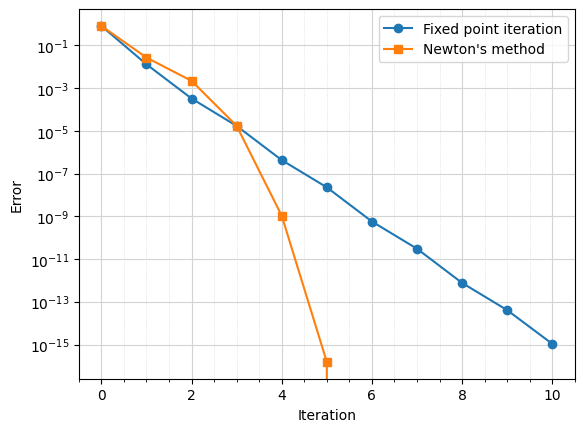

In [21]:
fig, ax = plt.subplots()
plt.semilogy( errHistFixedPt, 'o-',label='Fixed point iteration')
plt.semilogy( errHistNewton, 's-',label="Newton's method")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
ax.minorticks_on()
ax.grid(which='major', color='lightgray', linestyle='-', linewidth=0.8)
ax.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5)
plt.show()